# 9. Wavenet (CNN)

- Bengio et al. 2003 MLP LM <https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf>
- WaveNet 2016 from DeepMind <https://arxiv.org/abs/1609.03499>
- <https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/>

L'objectif est d'améliorer le modèle de langue au niveau des caractères en s'éloignant d'un simple perceptron multicouche (MLP) qui écrase immédiatement tous les caractères d'entrée en une seule couche cachée. Nous allons mettre en oeuvre une architecture hiérarchique inspirée de l'article **WaveNet** (2016). Le but est de fusionner progressivement les informations (deux caractères à la fois) afin de traiter plus efficacement les contextes plus longs.

# Reprise

In [1]:
import random

import torch
import torch.nn.functional as F


class Words(object):
    """Représente une liste de mots, ainsi que la liste ordonnée des caractères les composants."""

    EOS = '.'

    def __init__(self, filename):
        self.filename = filename
        self.words = open(self.filename, 'r').read().splitlines()
        self.nb_words = len(self.words)
        self.chars = sorted(list(set(''.join(self.words))))
        self.nb_chars = len(self.chars) + 1  # On ajoute 1 pour EOS
        self.ctoi = {c:i+1 for i,c in enumerate(self.chars)}
        self.ctoi[self.EOS] = 0
        self.itoc = {i:s for s,i in self.ctoi.items()}

    def __repr__(self):
        l = []
        l.append("<Words")
        l.append(f'  filename="{self.filename}"')
        l.append(f'  nb_words="{self.nb_words}"')
        l.append(f'  nb_chars="{self.nb_chars}"/>')
        return '\n'.join(l)

In [2]:
class Datasets:
    """Construits les jeu de données d'entraînement, de test et de validation.
    
    Prend en paramètres une liste de mots et la taille du contexte pour la prédiction.
    """

    def _build_dataset(self, lwords:list, context_size:int):
        X, Y = [], []
        for w in lwords:
            context = [0] * context_size
            for ch in w + self.words.EOS:
                ix = self.words.ctoi[ch]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix] # crop and append
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X, Y
    
    def __init__(self, words:Words, context_size:int, seed:int=42):
        # 80%, 10%, 10%
        self.shuffled_words = words.words.copy()
        random.shuffle(self.shuffled_words)
        self.n1 = int(0.8*len(self.shuffled_words))
        self.n2 = int(0.9*len(self.shuffled_words))
        self.words = words
        self.Xtr, self.Ytr = self._build_dataset(self.shuffled_words[:self.n1], context_size)
        self.Xdev, self.Ydev = self._build_dataset(self.shuffled_words[self.n1:self.n2], context_size)
        self.Xte, self.Yte = self._build_dataset(self.shuffled_words[self.n2:], context_size)


In [3]:
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

In [4]:
class FlattenConsecutive:
    """Plus ou moins <https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html>"""
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [5]:
class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [6]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [7]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [8]:
class Sequential:
    """<https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html>"""
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [21]:
class BengioFFNModel:
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, seed):
        torch.manual_seed(seed);
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.steps = 0
        self.create_model()

    def _create_model(self):
        self.model = Sequential([
            Embedding(self.nb_chars, self.e_dims),
            FlattenConsecutive(),
            Linear(self.e_dims * self.context_size, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
            Linear(self.n_hidden, self.nb_chars), BatchNorm1d(self.nb_chars),
        ])
        with torch.no_grad():
            self.model.layers[-1].gamma *= 0.1
    
    def create_model(self):
        self._create_model()
        self.parameters = self.model.parameters()
        for p in self.parameters:
            p.requires_grad = True
        self.nb_parameters = sum(p.nelement() for p in self.parameters)

    def forward(self, X, Y):
        logits = self.model(X)
        self.loss = F.cross_entropy(logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def train(self, datasets: Datasets, max_steps, mini_batch_size):
        lossi = []
        for i in range(max_steps):
            # minibatch construct
            ix = torch.randint(0, datasets.Xtr.shape[0], (mini_batch_size,))
            Xb, Yb = datasets.Xtr[ix], datasets.Ytr[ix]
            
            # forward pass
            self.forward(Xb, Yb)
        
            # backward pass
            self.backward()

            # update
            lr = 0.2 if i < 100000 else 0.02 # step learning rate decay
            self.update_grad(lr)
        
            # track stats
            if i % 10000 == 0:
                print(f"{i:7d}/{max_steps:7d}: {self.loss.item():.4f}")
            lossi.append(self.loss.log10().item())
        self.steps += max_steps
        return lossi

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        logits = self.model(X)
        loss = F.cross_entropy(logits, Y)
        return loss

    @torch.no_grad() # this decorator disables gradient tracking
    def training_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xtr, datasets.Ytr)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def test_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xte, datasets.Yte)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def dev_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xdev, datasets.Xdev)
        return loss.item()

    @torch.no_grad()
    def generate_word(self, itoc, g):
        for layer in self.model.layers:
            layer.training = False
        out = []
        context = [0] * self.context_size
        while True:
            logits = self.model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # Sample from the probability distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # Shift the context window
            context = context[1:] + [ix]
            # Store the generated character
            if ix != 0:
                out.append(ix)
            else:
                # Stop when encounting '.'
                break
        return ''.join(itoc[i] for i in out)

    def __repr__(self):
        l = []
        l.append("<BengioFFNModel")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

## Entraînement et sampling

In [10]:
words = Words('civil_mots.txt')
print(words)
context_size = 3
datasets = Datasets(words, context_size)
print(datasets)
vocab_size = words.nb_chars
e_dims = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the FFN
seed = 2147483647


<Words
  filename="civil_mots.txt"
  nb_words="7223"
  nb_chars="41"/>


In [22]:
nn = BengioFFNModel(e_dims, n_hidden, context_size, words.nb_chars, seed)
print(nn)

<BengioFFNModel
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  nb_parameters="15133"/>


In [23]:
max_steps = 200000
mini_batch_size = 32
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")

      0/ 200000: 3.7010
  10000/ 200000: 1.8070
  20000/ 200000: 1.9360
  30000/ 200000: 2.0421
  40000/ 200000: 1.8004
  50000/ 200000: 1.5737
  60000/ 200000: 1.7824
  70000/ 200000: 1.4953
  80000/ 200000: 1.6343
  90000/ 200000: 1.7238
 100000/ 200000: 1.5417
 110000/ 200000: 1.7352
 120000/ 200000: 1.2899
 130000/ 200000: 1.6082
 140000/ 200000: 1.9928
 150000/ 200000: 1.5761
 160000/ 200000: 2.6016
 170000/ 200000: 1.5545
 180000/ 200000: 1.5431
 190000/ 200000: 1.5238
train_loss=1.5285897254943848
val_loss=1.6962659358978271


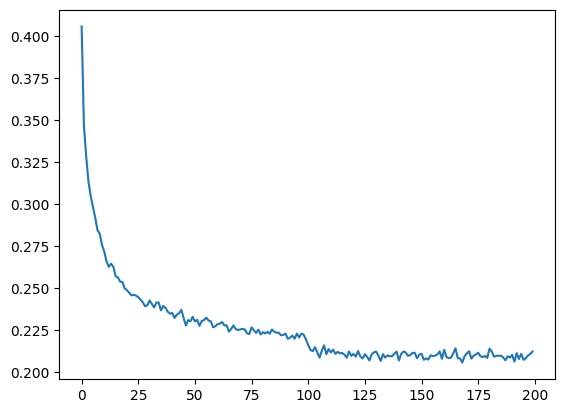

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [25]:
g = torch.Generator().manual_seed(seed + 10)
for _ in range(20):
    word = nn.generate_word(words.itoc, g)
    print(word)

aveilles
saienperçés
reconvera
prévalue
sucultlicieurs
déter
soire
assumet
indorelant
subsistement
accommés
solève
veules
facite
éclarenduellotifiquisteprofitechep
peunifie
prisée
didattre
libérée
rent


## Utiliser un contexte plus grand ?

In [26]:
context_size = 8
datasets = Datasets(words, context_size)
vocab_size = words.nb_chars
e_dims = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the FFN
seed = 2147483647


In [27]:
nn = BengioFFNModel(e_dims, n_hidden, context_size, words.nb_chars, seed)
print(nn)

<BengioFFNModel
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="8"
  nb_parameters="25133"/>


In [28]:
max_steps = 200000
mini_batch_size = 32
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")

      0/ 200000: 3.7017
  10000/ 200000: 1.9293
  20000/ 200000: 1.5415
  30000/ 200000: 1.3004
  40000/ 200000: 1.6041
  50000/ 200000: 1.4471
  60000/ 200000: 1.3692
  70000/ 200000: 1.7599
  80000/ 200000: 1.2130
  90000/ 200000: 2.1057
 100000/ 200000: 1.3104
 110000/ 200000: 1.5806
 120000/ 200000: 1.1999
 130000/ 200000: 1.2412
 140000/ 200000: 1.2012
 150000/ 200000: 1.5974
 160000/ 200000: 1.5689
 170000/ 200000: 1.3686
 180000/ 200000: 1.1966
 190000/ 200000: 1.1663
train_loss=1.2270640134811401
val_loss=1.6161370277404785


## Wavenet

In [35]:
ix = torch.randint(0, datasets.Xtr.shape[0], (4,))  # Batch de 4 exemples
Xb = datasets.Xtr[ix]
print(Xb)

tensor([[19, 19,  7, 20, 17, 16, 15,  6],
        [ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 5,  7, 20, 20, 11, 23,  7, 20],
        [17, 16, 20, 20, 31,  6,  7, 15]])


In [30]:
nn.model.layers[0].out.shape  # Embedding layer

torch.Size([6839, 8, 10])

In [31]:
nn.model.layers[1].out.shape  # Flatten layer

torch.Size([6839, 80])

In [32]:
nn.model.layers[2].out.shape  # First Linear layer

torch.Size([6839, 200])

In [36]:
(torch.randn(4,80) @ torch.randn(80,200)).shape

torch.Size([4, 200])

In [37]:
(torch.randn(4,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 200])

In [38]:
(torch.randn(4,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 200])

In [39]:
(torch.randn(4,5,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 5, 200])

In [40]:
(torch.randn(4,2,5,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 2, 5, 200])

In [41]:
# 0 1 2 3 4 5 6 7
# (0 1) (2 3) (4 5) (6 7)
# (a b) (c d)
# (e f)

In [42]:
(torch.randn(4,80) @ torch.randn(80,200)).shape

torch.Size([4, 200])

In [43]:
(torch.randn(4,4,20) @ torch.randn(20,200)).shape

torch.Size([4, 4, 200])

In [44]:
# Passer de [4,8,10] à [4,4,20] où les 10-d vecteurs consécutifs sont concaténés

In [45]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [46]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [47]:
e = torch.randn(4, 8, 10)

In [48]:
explicit = torch.cat([e[:,::2,:], e[:,1::2,:]], dim=2)

In [49]:
explicit.shape

torch.Size([4, 4, 20])

In [50]:
e.view(4,4,20).shape

torch.Size([4, 4, 20])

In [51]:
(e.view(4,4,20) == explicit).all()

tensor(True)

In [70]:
B = 4
T = 8
C = 10
e = torch.randn(B, T, C)
n = 2
e.view(B, T//n, C*n).shape

torch.Size([4, 4, 20])

In [71]:
B = 4
T = 2
C = 10
e = torch.randn(B, T, C)
n = 2
e = e.view(B, T//n, C*n)
e.shape

torch.Size([4, 1, 20])

In [54]:
e.squeeze(1).shape

torch.Size([4, 20])

Il faut que nous reprenions les classes introduites précédemment pour utiliser ces B, T et C.

### Nouvelles classes

In [55]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [56]:
class FlattenConsecutive:
  
    def __init__(self, n): # n = 2
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape  # 4, 8, 10
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

### Modèle Wavenet

In [60]:
def create_model_wavenet(self):
    self.model = Sequential([
        Embedding(self.nb_chars, self.e_dims),
        FlattenConsecutive(2), Linear(self.e_dims   * 2, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(self.n_hidden * 2, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(self.n_hidden * 2, self.n_hidden, bias=False), BatchNorm1d(self.n_hidden), Tanh(),
        Linear(self.n_hidden, self.nb_chars),
    ])
    with torch.no_grad():
        self.model.layers[-1].weight *= 0.1
BengioFFNModel._create_model = create_model_wavenet

### Entraînement

In [61]:
context_size = 8
datasets = Datasets(words, context_size)
vocab_size = words.nb_chars
e_dims = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the FFN
seed = 2147483647

In [59]:
#torch.set_default_device('mps')
#torch.get_default_device()

In [62]:
nn = BengioFFNModel(e_dims, n_hidden, context_size, words.nb_chars, seed)


In [63]:
max_steps = 200000
mini_batch_size = 32
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")

      0/ 200000: 3.7377
  10000/ 200000: 1.4646
  20000/ 200000: 1.5771
  30000/ 200000: 1.0538
  40000/ 200000: 1.3723
  50000/ 200000: 1.2684
  60000/ 200000: 1.4154
  70000/ 200000: 1.2276
  80000/ 200000: 1.2436
  90000/ 200000: 0.6402
 100000/ 200000: 1.3461
 110000/ 200000: 0.9522
 120000/ 200000: 1.0788
 130000/ 200000: 1.1689
 140000/ 200000: 1.1304
 150000/ 200000: 1.2926
 160000/ 200000: 1.0429
 170000/ 200000: 0.9127
 180000/ 200000: 1.1666
 190000/ 200000: 1.0528
train_loss=0.9970558881759644
val_loss=1.6977943181991577


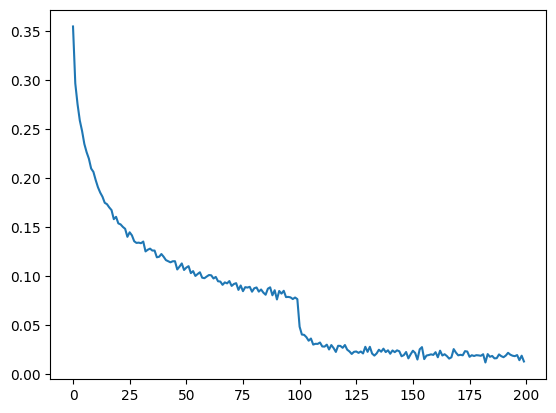

In [ ]:
t_lossi = torch.tensor(lossi).cpu()
plt.plot(t_lossi.view(-1, 1000).mean(1))

### Génération

In [68]:
#g = torch.Generator(device='mps').manual_seed(seed + 10)
g = torch.manual_seed(seed + 10)

In [69]:
for _ in range(20):
    word = nn.generate_word(words.itoc, g)
    print(word)

avenue
qu'avec
impératives
sport
présumés
cultif
leurs
sciences
liquidation
citre
représentement
judiciaire
soumettant
exceptionnés
bâti
mollaté
typoser
bordereaux
peutiennent
sécurisée
